# **CIS 5450 Final Project**
Team: Michael Li, Hemosoo Woo, Chaelsey Park

# Part 1: Project Introduction

As foodies, our team was interested in analyzing the different factors that contribute to a restaurant's success. We define "success" in terms of a restaurants rating. Looking through multiple datasets, we found a dataset based in Bengaluru, India that had the most data that we could analyze on. We initially put all of this data into `restaurants_df`. This holds the restaurant info, including the rating, location, and important training features. We will attempt to develop a better understanding of the factors that contribute to a high and low restaurant rating score (beside's obviously the food quality). Does the restaurant's location, food delivery service, average price have a correlation to the rating? That is what we want to find out. In the end, we want to determine if the same factors can lead to high ratings in the United States, or if these findings are specific to Bangalore, India.

Zomato is India's food delivery service app, very similar to Uber Eats, Doordash.

We detail the process in this notebook with visualizations and annotations. Our team is excited for you to read this notebook, and we are looking forward to your questions.

# Part 2: Data Loading + Wrangling

In this section, we will load our data and clean it up for analysis later.

## Part 2.1 Data Loading

### Part 2.1.1 Importing Libraries
We are interested in importing all the necessary libraries that will help us to pre-process, visualize, model, analyze, and train our data. These are notable python libraries such as pandas, numpy, matplotlib, or sklearn.

In [ ]:
# Including all necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import torch
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import folium
from folium.plugins import HeatMap
from xgboost import XGBRegressor

### Part 2.1.2 Importing Dataset

We must first download the path to the Kaggle dataset into our notebook.

In [ ]:
path = kagglehub.dataset_download("himanshupoddar/zomato-bangalore-restaurants")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/himanshupoddar/zomato-bangalore-restaurants/versions/1


Now we can directly access the csv file for our dataset, which we will read and store in a dataframe `restaurants_df`.

In [ ]:
import os

# List all files in the directory
print(os.listdir(path))
file_path = os.path.join(path, "zomato.csv")

# Dataset is saved into restaurants_df
restaurants_df = pd.read_csv(file_path)

['zomato.csv']


Let's take a look at our dataset and its structure.

In [ ]:
# View info about the dataset
restaurants_df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

We can now confirm that our dataframe includes all columns from the original dataset.

Note that some columns are repetitive, such as `listed_in(city)` and `location` which hold the same values.

Furthermore, there are some columns that we will not be using for our purposes, including the restaurant's phone number, the url to the restaurant's website, and even the name. Since we are less focused on the individual restaurants themselves and more the relationship between classifiable variables and the overall rating of the restaurant, phone numbers or names are too specific to each restaurant so they won't be of much help in finding a relationship or trend.

In [ ]:
restaurants_df.head(10)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari
5,https://www.zomato.com/bangalore/timepass-dinn...,"37, 5-1, 4th Floor, Bosco Court, Gandhi Bazaar...",Timepass Dinner,Yes,No,3.8/5,286,+91 9980040002\r\n+91 9980063005,Basavanagudi,Casual Dining,"Onion Rings, Pasta, Kadhai Paneer, Salads, Sal...",North Indian,600,"[('Rated 3.0', 'RATED\n Food 3/5\nAmbience 3/...",[],Buffet,Banashankari
6,https://www.zomato.com/bangalore/rosewood-inte...,"19/1, New Timberyard Layout, Beside Satellite ...",Rosewood International Hotel - Bar & Restaurant,No,No,3.6/5,8,+91 9731716688\r\n080 26740366,Mysore Road,Casual Dining,NaN,"North Indian, South Indian, Andhra, Chinese",800,"[('Rated 5.0', 'RATED\n Awesome food ??Great ...",[],Buffet,Banashankari
7,https://www.zomato.com/bangalore/onesta-banash...,"2469, 3rd Floor, 24th Cross, Opposite BDA Comp...",Onesta,Yes,Yes,4.6/5,2556,080 48653961\r\n080 48655715,Banashankari,"Casual Dining, Cafe","Farmhouse Pizza, Chocolate Banana, Virgin Moji...","Pizza, Cafe, Italian",600,"[('Rated 5.0', 'RATED\n I personally really l...",[],Cafes,Banashankari
8,https://www.zomato.com/bangalore/penthouse-caf...,"1, 30th Main Road, 3rd Stage, Banashankari, Ba...",Penthouse Cafe,Yes,No,4.0/5,324,+91 8884135549\r\n+91 9449449316,Banashankari,Cafe,"Pizza, Mocktails, Coffee, Nachos, Salad, Pasta...","Cafe, Italian, Continental",700,"[('Rated 3.0', ""RATED\n I had been to this pl...",[],Cafes,Banashankari
9,https://www.zomato.com/bangalore/smacznego-ban...,"2470, 21 Main Road, 25th Cross, Banashankari, ...",Smacznego,Yes,No,4.2/5,504,+91 9945230807\r\n+91 9743804471,Banashankari,Cafe,"Waffles, Pasta, Coleslaw Sandwich, Choco Waffl...","Cafe, Mexican, Italian, Momos, Beverages",550,"[('Rated 4.0', ""RATED\n Easy to locate\nVFM 3...",[],Cafes,Banashankari


## Section 2.2: Data Wrangling and Preprocessing
Our objective this section is to ensure that we have clean data that we can use for our purposes. We will only include certain columns that we are interested in and remove incomplete rows.

### 2.2.1 Keeping only necessary Columns

Some columns we don't use in our analysis, such as the website of the restaurant. Then we reduce the number of columns in our data set to 9 columns. Why we removed them:

`url`: As mentioned earlier, the actual website is different for every single restaurant and we believe it has little to no impact on the review that people give. Even if there is an impact, our analysis would only look at the url itself as a string rather than looking into the website, so it is essentially useless to us.

`address`: Although the address or more generally the location of the restaurant may seem to matter a lot in relation to the rating, we have other columns that are much easier to read and deal with for the region of the restaurant like the literaly `location` column. That column is much easier to read and deal with because there is a lot of overlap in the general locations that the restaurants are in compared to no overlap at all in the specific address of each restaurant.

`name`: Name could definitely have an impact on people's review/opinion of a particular restaurant, but we found that it is too difficult to measure as a quantitative piece of data since it is essentially just a string of characters. We also noted there are more impactful variables than `name` such as the cost, location, and ability to order online, which are much more objective rather than subjective.

`phone`: Similar to name or url, the phone number for each restaurant doesn't seem to have much of an impact on the review. The only reason for a phone number to have some impact is whether it's easy to type out or remember which are still very trivial impacts on the review of a restaurant, therefore we thought it would make sense to omit this field.

`dish_liked`: Specific dishes that people liked could definitely be impactful on the review for restaurants, but the issue is that there are too many different possible dish items for all the restaurants in our data, with similar named dishes that should technically be the counted as the same dish but would be difficult to implement for our purposes. Also, the `cuisines` column more accurately and effectively allows for us to quantitatively analyze general food trends because there is much more overlap in cuisines types compared to dishes for restaurants.

`reviews_list`: Since we are not dealing with word sentiment or natural language processing, we don't care about the actual reviews themselves in our case, other than the numerical value associated.

`menu_item`: Similar to `dish_liked`, there are just too many possible menu_items possible for every restaurant, and a lot of fields have an empty list, making this field difficult to use in our quantitative analysis.

`listed_in(city)`: As mentioned above, this is duplicate of the `location` column, which has a simpler title and appears first so we might as well just pick `location`.

In [ ]:
# Only keeping relevant columns that we will use to train/test our data
restaurants_df = restaurants_df[["online_order", "book_table", "rate", "votes", "location", "cuisines", "approx_cost(for two people)", "listed_in(type)"]]

print("Number of rows: ", len(restaurants_df))
restaurants_df.head(10)

Number of rows:  51717


,online_order,book_table,rate,votes,location,cuisines,approx_cost(for two people),listed_in(type)
0,Yes,Yes,4.1/5,775,Banashankari,"North Indian, Mughlai, Chinese",800,Buffet
1,Yes,No,4.1/5,787,Banashankari,"Chinese, North Indian, Thai",800,Buffet
2,Yes,No,3.8/5,918,Banashankari,"Cafe, Mexican, Italian",800,Buffet
3,No,No,3.7/5,88,Banashankari,"South Indian, North Indian",300,Buffet
4,No,No,3.8/5,166,Basavanagudi,"North Indian, Rajasthani",600,Buffet
5,Yes,No,3.8/5,286,Basavanagudi,North Indian,600,Buffet
6,No,No,3.6/5,8,Mysore Road,"North Indian, South Indian, Andhra, Chinese",800,Buffet
7,Yes,Yes,4.6/5,2556,Banashankari,"Pizza, Cafe, Italian",600,Cafes
8,Yes,No,4.0/5,324,Banashankari,"Cafe, Italian, Continental",700,Cafes
9,Yes,No,4.2/5,504,Banashankari,"Cafe, Mexican, Italian, Momos, Beverages",550,Cafes


### Part 2.2.2 Dropping null rows
First, we want to drop the rows with a null rating, in column `rate`, since it's the variable we're testing on.

In [ ]:
# Dropping rows with null data points
restaurants_df = restaurants_df.dropna().reset_index(drop = True)

print("Number of rows after dropping null: ", len(restaurants_df))

Number of rows after dropping null:  43682


### Part 2.2.3 Cleaning the "rate" column


We strictly want rows for which `rate` is a numerical value, so we'll clean up any rows that don't adhere to the invariant.

In [ ]:
# drop rows there the value for "rate" is NEW
restaurants_df = restaurants_df[restaurants_df["rate"] != "NEW"]
restaurants_df = restaurants_df[restaurants_df["rate"] != "-"]
restaurants_df["rate"] = restaurants_df["rate"].str.replace(r"/5\s*$", "", regex=True)
restaurants_df["rate"] = restaurants_df["rate"].astype(float)
restaurants_df.head(10)
len(restaurants_df)

41410

### Part 2.2.4 Adjusting datatypes

Two of the columns we want to use are `online_order` and `book_table` which is whether the restaurant offers these two options, but they are given as "Yes"/"No" values, which we will instead change to True/False boolean values, and then finally convert to 0s or 1s (for false and true respectively) to deal with strictly numerical values.

In [ ]:
# In the online_order and book_table columns, we will change the "Yes"/"No" values to True/False
restaurants_df["online_order"] = restaurants_df["online_order"].replace({"Yes": True, "No": False})
restaurants_df["book_table"] = restaurants_df["book_table"].replace({"Yes": True, "No": False})
restaurants_df["online_order"] = restaurants_df["online_order"].astype(int)
restaurants_df["book_table"] = restaurants_df["book_table"].astype(int)

<ipython-input-128-eb2a9c318300>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  restaurants_df["online_order"] = restaurants_df["online_order"].replace({"Yes": True, "No": False})
<ipython-input-128-eb2a9c318300>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  restaurants_df["book_table"] = restaurants_df["book_table"].replace({"Yes": True, "No": False})


Since we are given the types of cusines offered at every restaurant, we would like to utilize the number of cuisines in our project. We can create a column `num_cuisines` which contains the number of cuisines for every restaurant and drop the `cuisines` column from our dataset as follows. We have also printed the number of unique cuisines being served to further understand our data.

In [ ]:
# We want to create a column that counts the number of cuisines in the cuisines column
restaurants_df["num_cuisines"] = restaurants_df["cuisines"].str.split(", ").apply(len)

unique_cuisines = restaurants_df["cuisines"].unique()
print("Number of unique cuisines being served in Bangalore:", len(unique_cuisines))
unique_cuisines

# Drop cuisines column
restaurants_df.drop("cuisines", axis=1, inplace=True)

Number of unique cuisines being served in Bangalore: 2376


### Part 2.2.5 Renaming Columns + Exploding Columns into rows

For the sake of simplicity, we will rename the `approx_cost` column to `cost` and `listed_in(type)` to `type`.

In [ ]:
# Renaming columns to stay consistent
restaurants_df = restaurants_df.rename(columns = {"approx_cost(for two people)": "cost", "listed_in(type)": "type"})

Since the `cost` column gives us the estimated cost for two individuals, we will divide the values in half to find the cost for 1 person, which will better allow us to gauge an understanding of the data.

In [ ]:
# Covert the "cost" column to be numeric values
# Since cost is originally the estimated cost for 2 people, we divide by 2 to find the estimated cost for 1 person
restaurants_df["cost"] = restaurants_df["cost"].str.replace(",", "").astype(float)
restaurants_df["cost"] = restaurants_df["cost"] / 2
print(restaurants_df)

       online_order  book_table  rate  votes                    location  \
0                 1           1   4.1    775                Banashankari   
1                 1           0   4.1    787                Banashankari   
2                 1           0   3.8    918                Banashankari   
3                 0           0   3.7     88                Banashankari   
4                 0           0   3.8    166                Basavanagudi   
...             ...         ...   ...    ...                         ...   
43677             0           0   3.7     34                  Whitefield   
43678             0           0   2.5     81                  Whitefield   
43679             0           0   3.6     27                  Whitefield   
43680             0           1   4.3    236  ITPL Main Road, Whitefield   
43681             0           0   3.4     13  ITPL Main Road, Whitefield   

         cost           type  num_cuisines  
0       400.0         Buffet             3

In [ ]:
# Expanding the rest_type column into individual rows
# restaurants_df_extended = restaurants_df.assign(rest_type=restaurants_df['rest_type'].str.split(', ')).explode('rest_type', ignore_index=True)
# print(len(restaurants_df_extended))
# restaurants_df_extended.head(10)

### Part 2.2.6 Viewing Unique Column Values
Here, we can see that there are 92 unique neighborhoods in Bangalore. We will later perform hypothesis testing to determine if the neighborhood that a restaurant belongs in significantly impacts the rating score.

In [ ]:
# Print all the unique locations
unique_locations = restaurants_df["location"].unique()
print("Number of unique neighborhoods in Bangalore:", len(unique_locations))
unique_locations

Number of unique neighborhoods in Bangalore: 92


array(['Banashankari', 'Basavanagudi', 'Mysore Road', 'Jayanagar',
       'Kumaraswamy Layout', 'Rajarajeshwari Nagar', 'Vijay Nagar',
       'Uttarahalli', 'JP Nagar', 'South Bangalore', 'City Market',
       'Bannerghatta Road', 'BTM', 'Kanakapura Road', 'Bommanahalli',
       'Electronic City', 'Sarjapur Road', 'Wilson Garden',
       'Shanti Nagar', 'Koramangala 5th Block', 'Richmond Road', 'HSR',
       'Koramangala 7th Block', 'Bellandur', 'Marathahalli', 'Whitefield',
       'East Bangalore', 'Old Airport Road', 'Indiranagar',
       'Koramangala 1st Block', 'Frazer Town', 'MG Road', 'Brigade Road',
       'Lavelle Road', 'Church Street', 'Ulsoor', 'Residency Road',
       'Shivajinagar', 'Infantry Road', 'St. Marks Road',
       'Cunningham Road', 'Race Course Road', 'Commercial Street',
       'Vasanth Nagar', 'Domlur', 'Koramangala 8th Block', 'Ejipura',
       'Jeevan Bhima Nagar', 'Old Madras Road', 'Seshadripuram',
       'Kammanahalli', 'Koramangala 6th Block', 'Majestic'

# Part 3: Exploratory Data Analysis

Now that we have an understanding of our dataset, created summary statistics, and made adjustments as needed, we will dive into the dataset to uncover patterns, trends, and relationships. We examine how key attributes such as individual ratings, types, location, and costs influence overall restaurant success (measured by the restaurant rating) and highlight notable correlations. This analysis serves as a foundation for our predictive models.

## Section 3.1 Online ordering, table booking, prices, ratings

In this section, we analyze the relationships between online ordering, table booking, restaurant prices, and restaurants ratings.

### 3.1.1 Proportion of restaurants offering online orders and table booking

This pie chart illustrates the proportion of restaurants that offer online ordering and booking tables in advance versus those that do not. It provides an overview of how prevalent these features are in the dataset so we can further compare their relationships with other features.

online_order
1    27198
0    14212
Name: count, dtype: int64
book_table
0    35106
1     6304
Name: count, dtype: int64


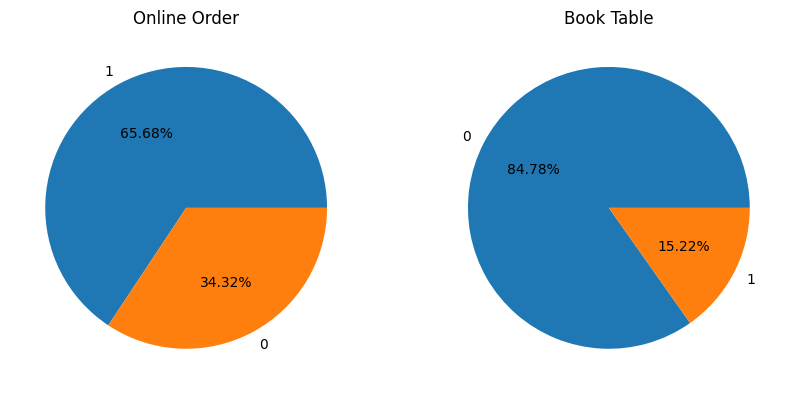

In [ ]:
# Visualize using a pie chart the proportion of online_order and with another pie chart, book_table, but groupby the restaurant name
online_order_counts = restaurants_df["online_order"].value_counts()
book_table_counts = restaurants_df["book_table"].value_counts()
print(online_order_counts)
print(book_table_counts)

# Creating two pie charts for both data points
fig, axs = plt.subplots(1, 2, figsize=(10,6))
axs[0].pie(online_order_counts, labels=online_order_counts.index, autopct='%1.2f%%')
axs[0].set_title('Online Order')
axs[1].pie(book_table_counts, labels=book_table_counts.index, autopct='%1.2f%%')
axs[1].set_title('Book Table')
plt.show()


**Takeaways**


*   65.68% offer ordering in advance.
*   15.22% offer booking tables in advance.



### 3.1.2 Correlation between restaurant price and ratings

To see if there is a relationship between restaurant pricing and customer ratings, we visualized the correlation in this scatterplot. The plot allows us to observe trends, as well as the density of restaurants across different price ranges.

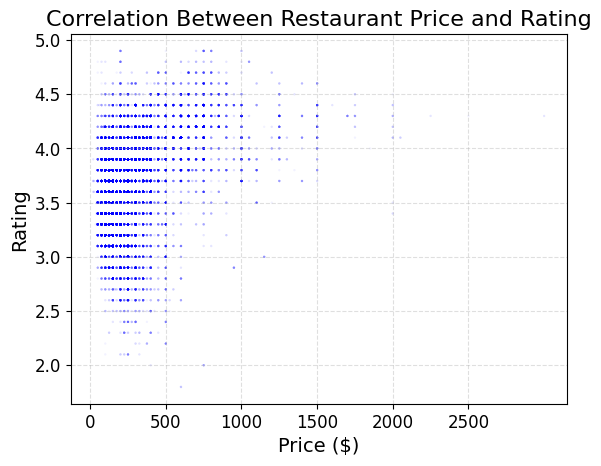

In [ ]:
plt.scatter(restaurants_df["cost"], restaurants_df["rate"], color='blue', alpha=0.05, edgecolor='none', s=3)  # Smaller, transparent points

# Customize the plot
plt.title("Correlation Between Restaurant Price and Rating", fontsize=16)
plt.xlabel("Price ($)", fontsize=14)
plt.ylabel("Rating", fontsize=14)
max_cost = max(restaurants_df["cost"])
plt.xticks(ticks=np.arange(0, max_cost, 500), fontsize=12)  # Reduce number of x-ticks
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)

# Show the plot
plt.show()

**Takeaways**


*   Most restaurants are priced below $500, indicated by the dense number of points in this range.
*   Ratings are generally spread out, more so concentrated between 3.0 and 4.0.

*   As the price increases beyond $1000, the ratings are much higher, clustering between 4.0 to 4.5.



### 3.1.3 Impact of online ordering on restaurant prices and ratings

This section focuses on comparing the ratings between restaurants that allow online ordering versus those that do not. The plots help us identify patterns and analyze whether this feature influences pricing and customer ratings.

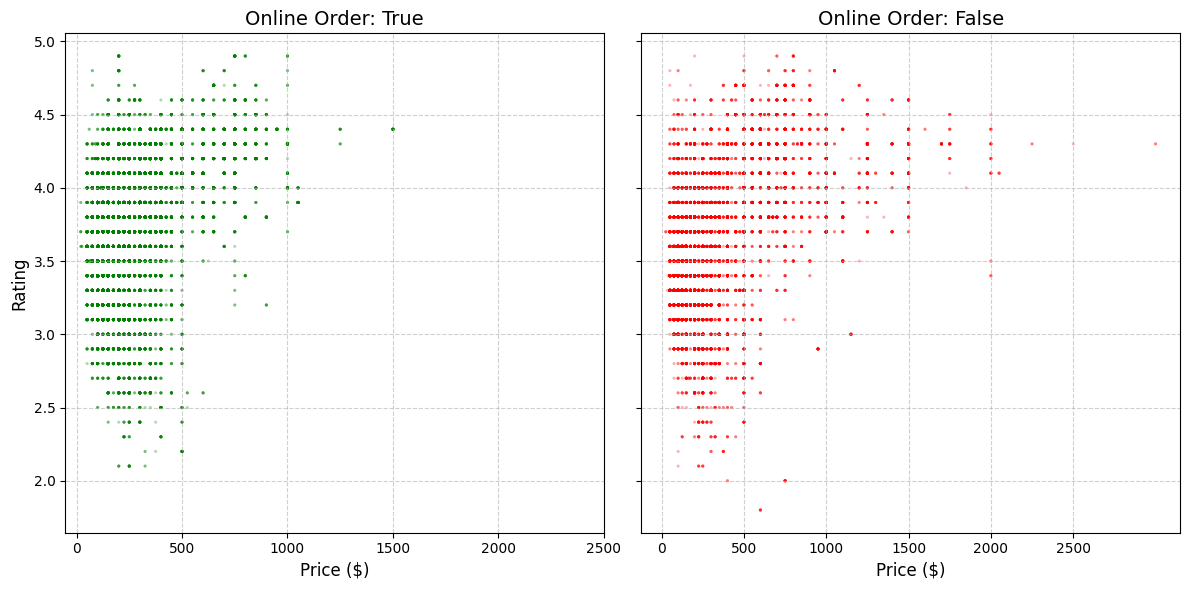

In [ ]:
true_data = restaurants_df[restaurants_df["online_order"] == True]
false_data = restaurants_df[restaurants_df["online_order"] == False]

# Create side-by-side scatterplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Two plots side by side

# Scatterplot for 'True'
axes[0].scatter(true_data["cost"], true_data["rate"], color='green', alpha=0.3, edgecolor='none', s=5)
axes[0].set_title("Online Order: True", fontsize=14)
axes[0].set_xlabel("Price ($)", fontsize=12)
axes[0].set_ylabel("Rating", fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_xticks(np.arange(0, max_cost, 500))

# Scatterplot for 'False'
axes[1].scatter(false_data["cost"], false_data["rate"], color='red', alpha=0.3, edgecolor='none', s=5)
axes[1].set_title("Online Order: False", fontsize=14)
axes[1].set_xlabel("Price ($)", fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_xticks(np.arange(0, max_cost, 500))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

**Takeaways**

*   The two plots are very similar, indicating that online ordering does not have a signficant impact on customer ratings. This may also be due to the fact that most restaurants offer online ordering, so this factor may almost be an expectation.



### 3.1.4 Impact of table booking on restaurant prices and ratings

This section focuses on comparing the ratings between restaurants that allow tables to be booked in advance versus those that do not. The plots help us identify patterns and analyze whether this feature influences pricing and customer ratings.

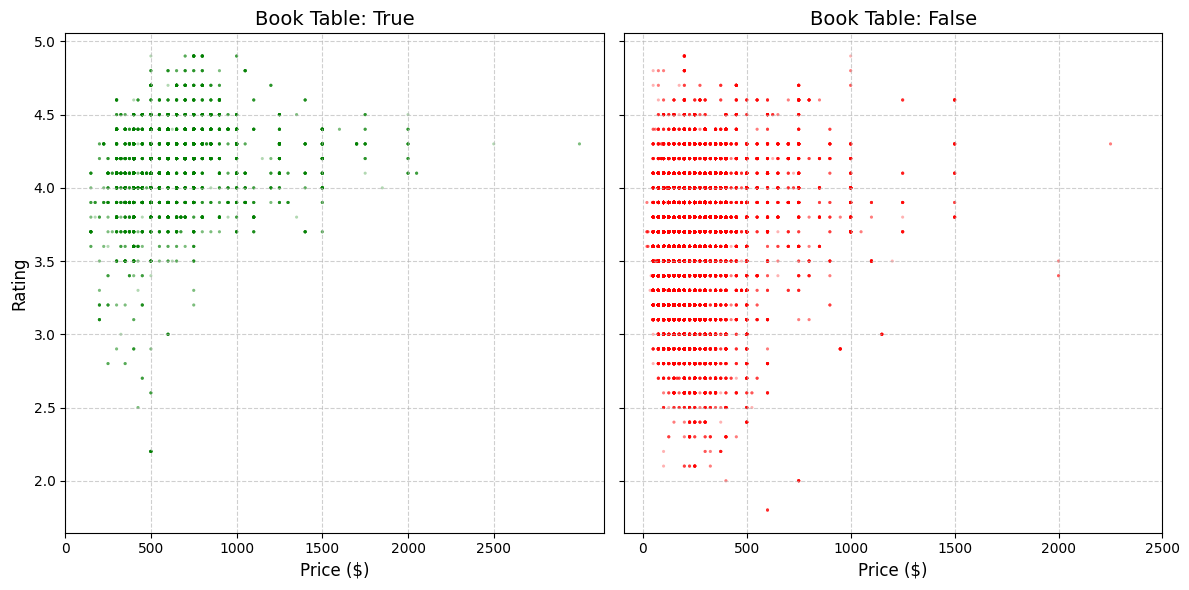

In [ ]:
true_data = restaurants_df[restaurants_df["book_table"] == True]
false_data = restaurants_df[restaurants_df["book_table"] == False]

# Create side-by-side scatterplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Two plots side by side

# Scatterplot for 'True'
axes[0].scatter(true_data["cost"], true_data["rate"], color='green', alpha=0.3, edgecolor='none', s=5)
axes[0].set_title("Book Table: True", fontsize=14)
axes[0].set_xlabel("Price ($)", fontsize=12)
axes[0].set_ylabel("Rating", fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_xticks(np.arange(0, max_cost, 500))

# Scatterplot for 'False'
axes[1].scatter(false_data["cost"], false_data["rate"], color='red', alpha=0.3, edgecolor='none', s=5)
axes[1].set_title("Book Table: False", fontsize=14)
axes[1].set_xlabel("Price ($)", fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_xticks(np.arange(0, max_cost, 500))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

**Takeaways**

*   Restaurants that allow table booking tend to have higher ratings, concetrated in the 4.0-5.0 range. This indicates that this feature may correlate with better customer sastisfaction.
*   There are more restaurants with table booking beyond the $500 range, which makes sense as higher-end spots tend to offer this feature.
*   Amongst the restaurants that do not offer table booking, the ratings are very dispersed, indicating that the unavailability of this feature does not significantly impact these restaurants.



### 3.1.5 Distribution of customer ratings

The histogram illustrates the frequency of ratings by customers. The chart provides an overview of the most common ratings as well as the spread. This helps us identify whether ratings are skewed and the general performance of restaurants.

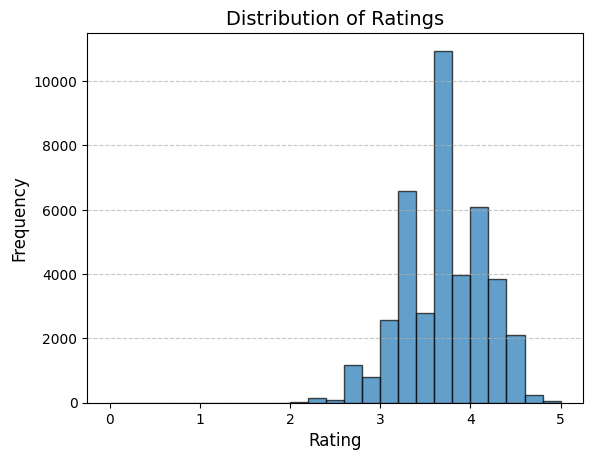

In [ ]:
plt.hist(restaurants_df["rate"], bins=25, edgecolor='black', alpha=0.7, range=(0, 5))

# Customize the plot
plt.title("Distribution of Ratings", fontsize=14)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

**Takeaways**

*   Ratings are heavily concentrated between 3.5 and 4.5, with a peak around 3.85. This indicates a moderately high customer satisfaction and we can use this general understanding to help us identify future trends.
*   There are very few ratings that are very low (less than 2.5) or very good (5.0), suggesting that it is difficult for customers to have signficantly strong sentiments on restaurants.



## Section 3.2 Location-based trends

###3.2.1 Location-based analysis of cost and rating

This section explores the relationship between restaurant location and two key metrics: average cost and average rating.  After grouping data by location, we calculate and visualize the top 10 and bottom 10 locations in terms of cost and rating. We used these four individual bar charts to help informs us on the relationships between cost, ratings, and location.

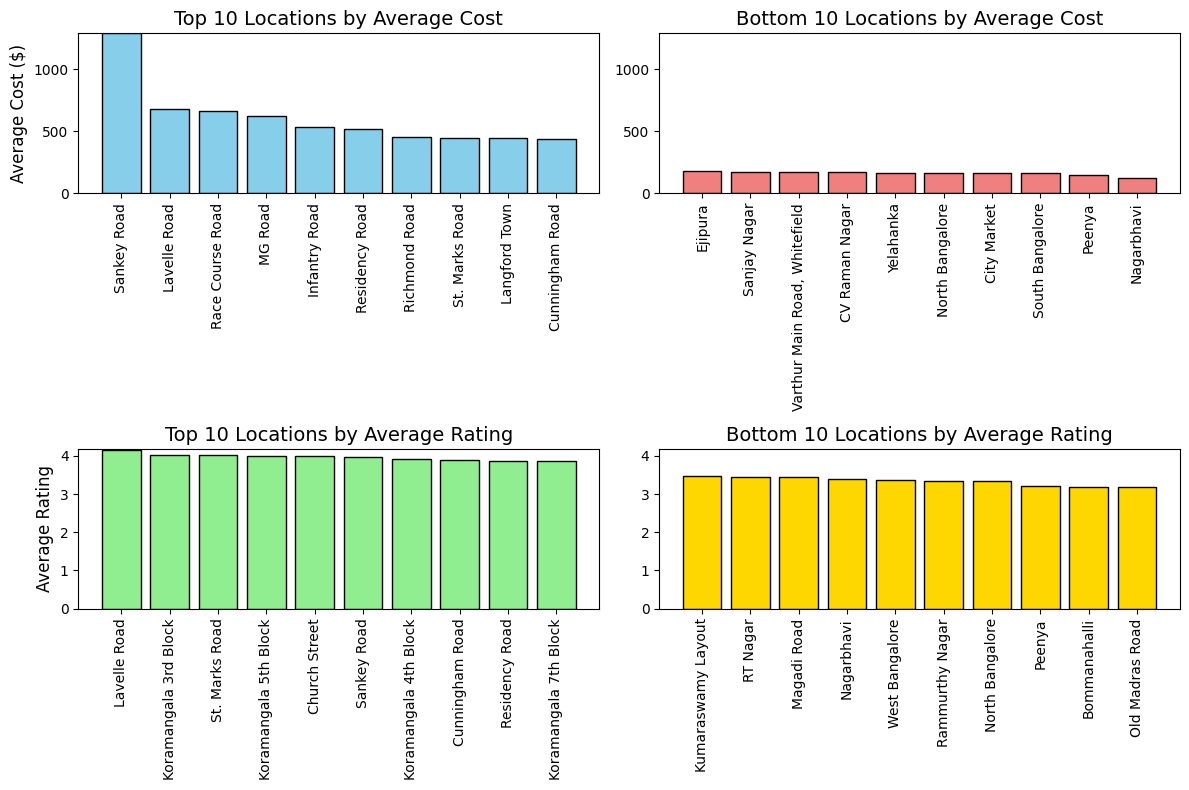

In [ ]:
avg_cost = restaurants_df.groupby("location")["cost"].mean().sort_values(ascending=False)
avg_rating = restaurants_df.groupby("location")["rate"].mean().sort_values(ascending=False)

# Get top and bottom 10 for cost and rating
top10_cost = avg_cost.head(10)
bottom10_cost = avg_cost.tail(10)
top10_rating = avg_rating.head(10)
bottom10_rating = avg_rating.tail(10)

# Determine consistent y-axis limits
cost_ymax = max(avg_cost.max(), avg_cost.min() + 10)  # Slight adjustment for visibility
rating_ymax = max(avg_rating.max(), avg_rating.min() + 1)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot top 10 average cost
axes[0, 0].bar(top10_cost.index, top10_cost.values, color="skyblue", edgecolor="black")
axes[0, 0].set_title("Top 10 Locations by Average Cost", fontsize=14)
axes[0, 0].set_ylabel("Average Cost ($)", fontsize=12)
axes[0, 0].tick_params(axis="x", rotation=90, labelsize=10)
axes[0, 0].set_ylim(0, cost_ymax)

# Plot bottom 10 average cost
axes[0, 1].bar(bottom10_cost.index, bottom10_cost.values, color="lightcoral", edgecolor="black")
axes[0, 1].set_title("Bottom 10 Locations by Average Cost", fontsize=14)
axes[0, 1].tick_params(axis="x", rotation=90, labelsize=10)
axes[0, 1].set_ylim(0, cost_ymax)  # Same y-axis scale as top 10 cost

# Plot top 10 average rating
axes[1, 0].bar(top10_rating.index, top10_rating.values, color="lightgreen", edgecolor="black")
axes[1, 0].set_title("Top 10 Locations by Average Rating", fontsize=14)
axes[1, 0].set_ylabel("Average Rating", fontsize=12)
axes[1, 0].tick_params(axis="x", rotation=90, labelsize=10)
axes[1, 0].set_ylim(0, rating_ymax)

# Plot bottom 10 average rating
axes[1, 1].bar(bottom10_rating.index, bottom10_rating.values, color="gold", edgecolor="black")
axes[1, 1].set_title("Bottom 10 Locations by Average Rating", fontsize=14)
axes[1, 1].tick_params(axis="x", rotation=90, labelsize=10)
axes[1, 1].set_ylim(0, rating_ymax)  # Same y-axis scale as top 10 rating

# Adjust layout
plt.tight_layout()
plt.show()

**Takeaways**


*   We noticed that both top ten locations had 5 out of 10 locations in common (Lavelle Road, Sankey Road, Residency Road, Cunningham Road, and St. Marks Road). This suggests a strong correlation between higher pricing and higher customer satisfaction in these locations. This intuitively makes sense as higher costs are typically associated with better customer experiences that justify the price, whether it be better food quality or service. The overlap  indicates a higher concentration of pricier restaurants in these locations that also prioritize quality, and that there are more customers that are willing to pay higher prices. These results are also supported by the correlation between price and rating above in part 3.1.2.
*   In the bottom ten locations, the two charts had 3 out of 10 locations (Peenya, North Bangalore, Nagarbhavi). This indicates a weaker correlation between cost and rating in these lower-performing areas, compared to the top-performing areas. In other words, low costs may not be connected to lower ratings, and vice versa. Other factors may be of more signficant indicators in these areas. The overlapping locations may be due to the fact that they face multiple challenges, such as fewer resources or lower-income areas, that make them underperform on both metrics.



### 3.2.2 Distribution of ratings by location

To analyze how restaurant ratings are distributed across different locations, we utilized a boxplot visualization after grouping and sorting the data based on average rating. We chose a boxplot to highlight the tendencies and variability in ratings for each location. We excluded outliers for a clearer understanding and sorted the locations in descending order of average rating to explore trends. This analysis helps us uncover any location-specific patterns or regional influences on restaurant success.

<ipython-input-140-8d9b36968413>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=restaurants_df, x="location", y="rate", palette="Set3", order=sorted_locations, showfliers=False)


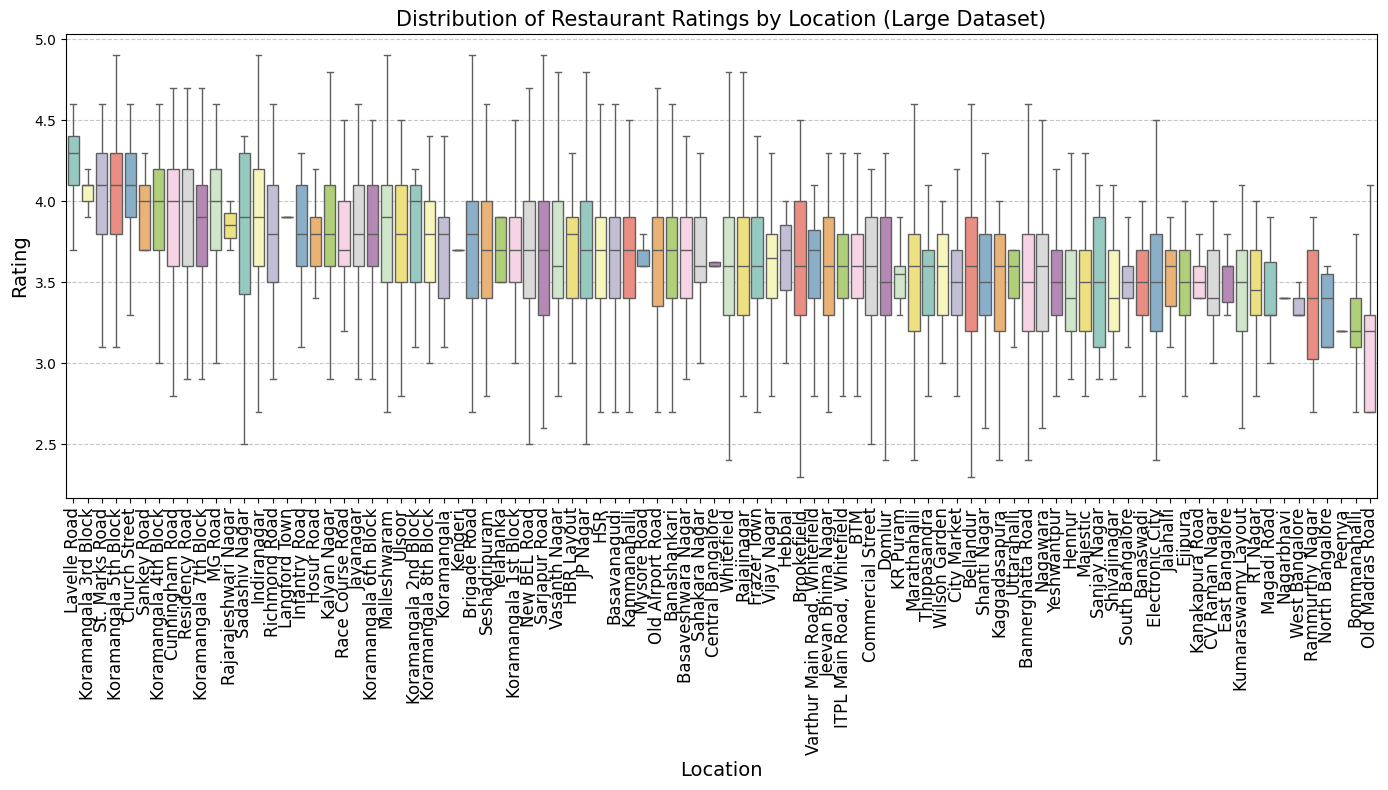

In [ ]:
# Sort restaurants_df group by location and sort by average rating in ascending order
sorted_locations = restaurants_df.groupby("location")["rate"].mean().sort_values(ascending=False).index

# Reorder the DataFrame based on the sorted locations
restaurants_df["location"] = pd.Categorical(restaurants_df["location"], categories=sorted_locations, ordered=True)

# Create the boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=restaurants_df, x="location", y="rate", palette="Set3", order=sorted_locations, showfliers=False)

# Customize the plot
plt.title("Distribution of Restaurant Ratings by Location (Large Dataset)", fontsize=15)
plt.xlabel("Location", fontsize=14)
plt.ylabel("Rating", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

## Section 3.3 Restaurant Type-based Trends

### 3.3.1 Distribution of restaurant ratings by types

To explore the variation in restaurant ratings based on different types of restaurants, we first grouped the data by type and sorted them by rating to better gain insights on which types consistently perform better. We chose to use a boxplot to visualize the distribution of ratings for each type, helping us identify how restaurant category is tied to satisfaction.

<Figure size 1200x800 with 0 Axes>

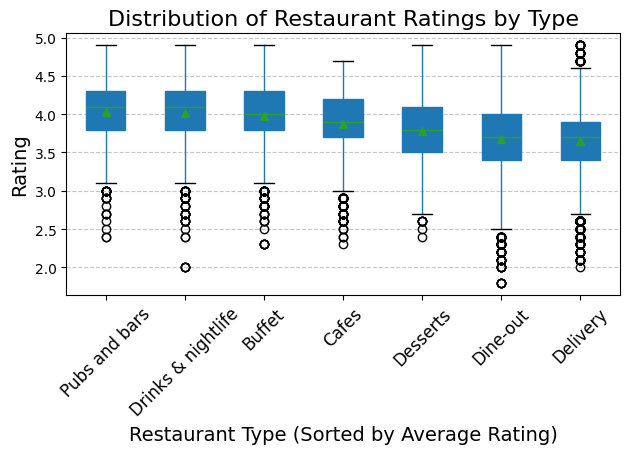

In [ ]:
sorted_types = (
    restaurants_df.groupby("type")["rate"]
    .mean()
    .sort_values(ascending=False)
    .index
)

# Reorder the "type" column based on sorted order
restaurants_df["type"] = pd.Categorical(restaurants_df["type"], categories=sorted_types, ordered=True)

# Create the boxplot
plt.figure(figsize=(12, 8))
restaurants_df.boxplot(column="rate", by="type", grid=False, patch_artist=True, showmeans=True)

# Customization
plt.title("Distribution of Restaurant Ratings by Type", fontsize=16)
plt.suptitle("")
plt.xlabel("Restaurant Type (Sorted by Average Rating)", fontsize=14)
plt.ylabel("Rating", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

**Takeaways**

*   "Drinks & Nightlife" and "Pubs and bars" which are similar have the highest average ratings, indicating that restaurants with alcholic beverages are generally well-regarded by customers.
*   Types like "dine-out" exhibit wider variability in ratings, suggesting that customer experiences may differ significantly within these catgories.
*   "Delivery" and "dine-out" have lower ratings compared to the other types, which may also reflect differences in customer expectations or inconsistencies in quality. This makes sense as these types tend to have more diverse experiences and food options.
*   Restaurant types that focus on in-person experiences tend to have higher ratings, which may potentially be explained by ambiance and social value. There may be limitations in replicating the in-person experience (food is not as fresh, for example), which affects ratings.





## Section 3.4 Feature Preprocessing and Correlation analysis

In [ ]:
encoder = OneHotEncoder(sparse_output=False, drop = 'first')

### 3.4.1 Features Heatmap

In this section, we will perform a correlation analysis of the numerical features in this dataset. We first excluded the non-numerical features, location and type. Then we standardized the numerical features using StandardScaler to ensure uniformity in scale. We used a heatmap to visualize the pairwise correlation coefficients between the standardized numerical features. This helps us identify multicollinearity, strong relationships, as well as irrelevant or weak relationships, which can guide us for further analysis and model building.

In [ ]:
restaurants_df

,online_order,book_table,rate,votes,location,cost,type,num_cuisines
0,1,1,4.1,775,Banashankari,400.0,Buffet,3
1,1,0,4.1,787,Banashankari,400.0,Buffet,3
2,1,0,3.8,918,Banashankari,400.0,Buffet,3
3,0,0,3.7,88,Banashankari,150.0,Buffet,2
4,0,0,3.8,166,Basavanagudi,300.0,Buffet,2
...,...,...,...,...,...,...,...,...
43677,0,0,3.7,34,Whitefield,400.0,Pubs and bars,2
43678,0,0,2.5,81,Whitefield,400.0,Pubs and bars,4
43679,0,0,3.6,27,Whitefield,750.0,Pubs and bars,1
43680,0,1,4.3,236,"ITPL Main Road, Whitefield",1250.0,Pubs and bars,1


In [1]:
to_encode = ["location", "type"]
not_encode = ["online_order", "book_table", "rate", "votes", "cost", "num_cuisines"]

In [ ]:
scaler = StandardScaler()
restaurants_df[not_encode] = scaler.fit_transform(restaurants_df[not_encode])

In [ ]:
no_encoded_df = restaurants_df.drop(columns=to_encode)

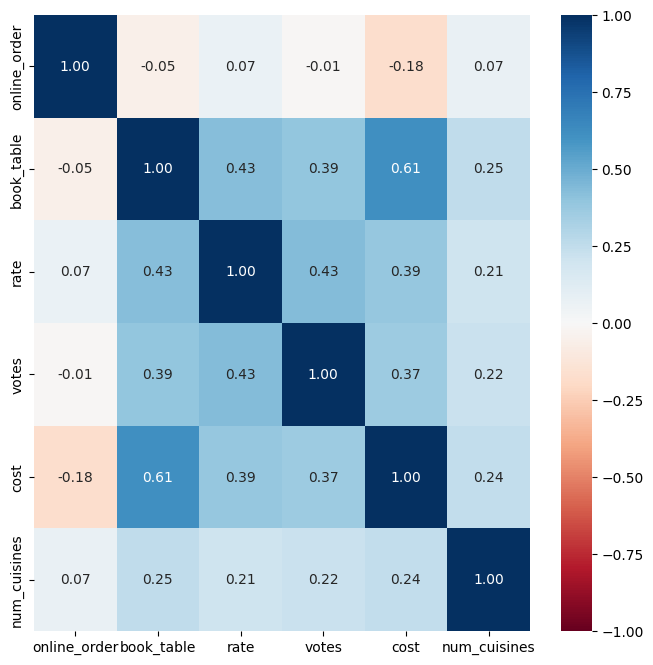

In [ ]:
plt.figure(figsize=(8,8))

# Calculate the correlation matrix
fig = sns.heatmap(data = no_encoded_df.corr(), cmap = 'RdBu', vmin = -1, vmax = 1, annot = True, fmt=".2f")
plt.show()

**Takeaways**


*   We can see that the strongest correlation is between being able to book a table and the cost (0.61). This makes sense as it is more common for pricier restaurants to have table booking and is also supported by our analysis in part 3.1.4.
*   There is a moderately positive correlation (0.43) between customer ratings and votes (number of ratings). This is intuitive as highly rated restaurants tend to receive more customers, hence more votes.
*   There is also a correlation between restaurants that offer table booking and customer ratings (0.43), which could reflect the convenience in being able to book tables in advance.
*   There is almost no correlation between online ordering and any other feature, indicating that this option does not cause a strong impact.







# Part 4: Data Preprocessing for Machine Learning

## Section 4.1 One-Hot Encoding

Since our machine learning algorithms for our modeling algorithms require numeric inputs, our categorical variables must be converted so that the models can interpret them. Here, we will be utilizing One-Hot Encoding as follows:


1.   Use a One-Hot Encoder to transform categorical columns `to_encode` (defined in 3.4.1) into binary indicator variables. Each unique category within the columns is converted into a separate column, where a value of 1 indicates the presence of that category for a given row, and 0 indicates otherwise.
2.   Our new encoded data is stored in a new DataFrame `encoded_columns_df`. We will then concatenate the newly encoded columns with the original DataFrame `restaurants_df` and drop the original categorical columns as they are no longer needed. Hence, the resulting DataFrame `restaurants_df_encoded` will contain all the data in a fully numeric format, now ready to be used for our models.



In [ ]:
restaurants_df = restaurants_df.reset_index(drop=True)

In [ ]:
# Using One Hot Encoder to encode some non-numeric values

# Fit and transform the columns
encoded_data = encoder.fit_transform(restaurants_df[to_encode])

# Create a DataFrame for the encoded columns
encoded_columns_df = pd.DataFrame(
    encoded_data,
    columns=encoder.get_feature_names_out(to_encode)
)


# Concatenate the one-hot-encoded columns back to the original DataFrame
restaurants_df_encoded = pd.concat([restaurants_df, encoded_columns_df], axis=1)

# Drop the original columns that were encoded
restaurants_df_encoded = restaurants_df_encoded.drop(columns=to_encode)
restaurants_df_encoded

,online_order,book_table,rate,votes,cost,num_cuisines,location_Banashankari,location_Banaswadi,location_Bannerghatta Road,location_Basavanagudi,...,location_Whitefield,location_Wilson Garden,location_Yelahanka,location_Yeshwantpur,type_Cafes,type_Delivery,type_Desserts,type_Dine-out,type_Drinks & nightlife,type_Pubs and bars
0,0.722868,2.359840,0.906831,0.479415,0.423577,0.341982,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.722868,-0.423758,0.906831,0.493009,0.423577,0.341982,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.722868,-0.423758,0.226017,0.641407,0.423577,0.341982,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.383378,-0.423758,-0.000921,-0.298826,-0.653198,-0.429004,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.383378,-0.423758,0.226017,-0.210467,-0.007133,-0.429004,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41405,-1.383378,-0.423758,-0.000921,-0.359998,0.423577,-0.429004,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41406,-1.383378,-0.423758,-2.724175,-0.306756,0.423577,1.112968,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41407,-1.383378,-0.423758,-0.227859,-0.367928,1.931062,-1.199990,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41408,-1.383378,2.359840,1.360706,-0.131170,4.084612,-1.199990,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
restaurants_df

,online_order,book_table,rate,votes,location,cost,type,num_cuisines
0,0.722868,2.359840,0.906831,0.479415,Banashankari,0.423577,Buffet,0.341982
1,0.722868,-0.423758,0.906831,0.493009,Banashankari,0.423577,Buffet,0.341982
2,0.722868,-0.423758,0.226017,0.641407,Banashankari,0.423577,Buffet,0.341982
3,-1.383378,-0.423758,-0.000921,-0.298826,Banashankari,-0.653198,Buffet,-0.429004
4,-1.383378,-0.423758,0.226017,-0.210467,Basavanagudi,-0.007133,Buffet,-0.429004
...,...,...,...,...,...,...,...,...
41405,-1.383378,-0.423758,-0.000921,-0.359998,Whitefield,0.423577,Pubs and bars,-0.429004
41406,-1.383378,-0.423758,-2.724175,-0.306756,Whitefield,0.423577,Pubs and bars,1.112968
41407,-1.383378,-0.423758,-0.227859,-0.367928,Whitefield,1.931062,Pubs and bars,-1.199990
41408,-1.383378,2.359840,1.360706,-0.131170,"ITPL Main Road, Whitefield",4.084612,Pubs and bars,-1.199990


## Section 4.2: Feature and Target Separation

The target variable `rate` is the value our model will predict. It is extracted from the DataFrame and is stored in a separate variable, `restaurants_target`. The remaining columns, which will be the inputs to our model, are stored in `restaurants_features`.

In [ ]:
# Extract target from dataframe
restaurants_target = restaurants_df_encoded['rate']

# Extract features from dataframe
restaurants_features = restaurants_df_encoded.drop('rate', axis = 1)

## Section 4.2: Train-Test Split

This step divides the dataset into training and testing subsets to prepare for our model. The training set (`X_train`, `y_train`) is used to train the model and the test set (`X_test`, `t_test`) is used to evaluate the model's performance on unseen data. We believed an 80/20 split would be conventional and sufficient for a robust evaluation. We set our `random_state` to 42, ensuring that the split is reproducible so we would have consistent results.

In [ ]:
# Conduct 80/20 train-test split with random_state = seed = 42
seed = 42
X_train, X_test, y_train, y_test = train_test_split(restaurants_features, restaurants_target, test_size=0.2, random_state=seed)

In [ ]:
restaurants_df_encoded

,online_order,book_table,rate,votes,cost,num_cuisines,location_Banashankari,location_Banaswadi,location_Bannerghatta Road,location_Basavanagudi,...,location_Whitefield,location_Wilson Garden,location_Yelahanka,location_Yeshwantpur,type_Cafes,type_Delivery,type_Desserts,type_Dine-out,type_Drinks & nightlife,type_Pubs and bars
0,0.722868,2.359840,0.906831,0.479415,0.423577,0.341982,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.722868,-0.423758,0.906831,0.493009,0.423577,0.341982,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.722868,-0.423758,0.226017,0.641407,0.423577,0.341982,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.383378,-0.423758,-0.000921,-0.298826,-0.653198,-0.429004,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.383378,-0.423758,0.226017,-0.210467,-0.007133,-0.429004,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41405,-1.383378,-0.423758,-0.000921,-0.359998,0.423577,-0.429004,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41406,-1.383378,-0.423758,-2.724175,-0.306756,0.423577,1.112968,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41407,-1.383378,-0.423758,-0.227859,-0.367928,1.931062,-1.199990,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41408,-1.383378,2.359840,1.360706,-0.131170,4.084612,-1.199990,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
restaurants_df

,online_order,book_table,rate,votes,location,cost,type,num_cuisines
0,0.722868,2.359840,0.906831,0.479415,Banashankari,0.423577,Buffet,0.341982
1,0.722868,-0.423758,0.906831,0.493009,Banashankari,0.423577,Buffet,0.341982
2,0.722868,-0.423758,0.226017,0.641407,Banashankari,0.423577,Buffet,0.341982
3,-1.383378,-0.423758,-0.000921,-0.298826,Banashankari,-0.653198,Buffet,-0.429004
4,-1.383378,-0.423758,0.226017,-0.210467,Basavanagudi,-0.007133,Buffet,-0.429004
...,...,...,...,...,...,...,...,...
41405,-1.383378,-0.423758,-0.000921,-0.359998,Whitefield,0.423577,Pubs and bars,-0.429004
41406,-1.383378,-0.423758,-2.724175,-0.306756,Whitefield,0.423577,Pubs and bars,1.112968
41407,-1.383378,-0.423758,-0.227859,-0.367928,Whitefield,1.931062,Pubs and bars,-1.199990
41408,-1.383378,2.359840,1.360706,-0.131170,"ITPL Main Road, Whitefield",4.084612,Pubs and bars,-1.199990


# Part 5: Model Development

Now that we have prepared our dataset, we can begin developing our models which will predict the overall restaurant rating.

## Section 5.1: Linear Regression Model

We will first use a simple Linear Regression model trained on our training dataset (`X_train`, `y_train`). The model predicts the target variable `rate` for the test set `X_test`, producing `y_pred` which represents the predicted ratings. We then evaluate how well our model explains the variability in the target variable by calculating the R^2 score on the training data then the test data, which indicates how well the model generalizes to unseen data. We also compute the mean squared error to quantify the average squared difference between the actual ratings `y_test` and predicted ratings `y_pred`. This provides a baseline model for further comparisons.

In [ ]:
# Fit a linear regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Predict on transformed test data using the linear regression model
y_pred = reg.predict(X_test)

# R^2 value calculation
lin_reg_score_test = reg.score(X_test, y_test)
lin_reg_score_train = reg.score(X_train, y_train)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

print('Test Set R^2 value: ' + str(lin_reg_score_test))
print('Train Set R^2 value: ' + str(lin_reg_score_train))
print('Mean Squared Error: ' + str(mse))

Test Set R^2 value: 0.339657037052961
Train Set R^2 value: 0.35218237232552796
Mean Squared Error: 0.656084531994313


**Results**


*   The test set R^2 value is 0.34, meaning that the model explains approximately 34% of the variance in the target variable `rate` on the test dataset (that was unseen). This is relatively low, indicating that the model only captures a small proportion of the variability in restaurant ratings. This could potentially be due to nonlinear relationships in the data that the regression cannot capture or signficant features not being represented adequately. Either way, a linear regression does not fully capture the complexity of the data, calling for other models that will improve the R^2 value.
*   Similarly, the training set R^2 is 0.35, which further demonstrates the underfitting of our linear regression model. Since the two R^2 values are similar, however, we can be confident that the model is not overfitting on the training dataset.
*   Our MSE of 0.66 suggests that there is a moderate level of error in the predictions, meaning that the predicted values deviate from the actual ratings. Note that the target variable `rate` is between 0 and 5.





## Section 5.2: XGBoost Regression

### 5.2.1 Initial model training and evaluation

To create a more accurate model, we trained an XGBoost Regression model on our training dataset. We instantiated the regressor with hyperparameters such as eta to control the learning rate, max_depth to set a maximum depth of each tree, and the seed to ensure reproducibility once again. The predictions for `rate` are made on both the training and testing datasets, producing `xgbr_pred_train` and `xgbr_pred_test`. We again measure the model's performance using the R^2 score and the mean squared error.

In [ ]:
# Instatiate a XGBRegressor model
xgbr = XGBRegressor(eta=0.1, max_depth=10, seed=42)

# Fit a model
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Predict the target variable for the training/test set
xgbr_pred_train = xgbr.predict(X_train)
xgbr_pred_test = xgbr.predict(X_test)

# Evaluate the model
xgbr_r2_train = r2_score(y_train, xgbr_pred_train)
xgbr_r2_test = r2_score(y_test, xgbr_pred_test)
mse = mean_squared_error(y_test, xgbr_pred_test)

print('Test Set R^2 value: ' + str(xgbr_r2_test))
print('Train Set R^2 value: ' + str(xgbr_r2_train))
print('Mean Squared Error: ' + str(mse))

Test Set R^2 value: 0.7127165964959912
Train Set R^2 value: 0.7656303306415178
Mean Squared Error: 0.28543076539573536


**Results**


*   Compared to the linear regression model, we can see that this regression is much more representative of the dataset, with a test set R^2 value of 0.7127 and a train set R^2 value of 0.7656. The similar values again suggest that the model is not significantly overfitting on the training set and is relatively generalized.
*   This model gave us a much smaller mean squared error as well compared to the MSE from the linear regression model.
*   However, we believed that using hyperparameter tuning could further improve the model.




### 5.2.2 Hyperparameter tuning with Grid Search

In order to optimize the XGBoost Regression model, we will systematically search for the best combination of hyperparameters using Grid Search. We defined a range of values for key hyperparameters, `n_estimators`, `max_depth`, and `learning_rate`. GridSearchCV is used to evaluate all combinations of hyperparameter values and perform cross-validation with `cv=5` which assesses the performance of the model on different susbets of the training data. The R^2 value is used to evaluate the different combinations and the best one will be selected. Our goal is to refine the model and improve its ability to generalize by identifying the most optimal balance between complexity and performance.

In [ ]:
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [5, 18, None],
    'learning_rate': [0.02, 0.1, 0.15]
}
# param_grid = {
#     'n_estimators': [100],
#     'max_depth': [5],
#     'learning_rate': [0.02]
# }


xgb = XGBRegressor(random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',  # r^2 scoring
    cv=5,
    verbose=True,
    n_jobs=-1
)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best R^2:", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'learning_rate': 0.1, 'max_depth': 18, 'n_estimators': 500}
Best R^2: 0.8599590151148127


**Results**


*   The best combination of hyperparameters for the XGBoost regression model is `n_estimators=500`, `max_depth=18`, and `learning_rate=0.1`. The high number of estimators (trees) enhances performance, the moderate depth allows the model to capture complex patterns while avoiding overfitting, and the moderate learning rate helps converge effectively without overshooting.
*   The best R^2 score achieved during cross-validation is 0.8599, which is far more representative than the linear regression model and the baseline XGBoost model. This indicates that the model generalizes very well to unseen data and is far more able to explain the variance across the dataset. Hyperparameter tuning significantly improved the models' performance, as the R^2 value is higher than the value from earlier without the tuning. This can be explained by the fact that the tuned model is more complex, leveraging deeper trees and more boosting rounds.



## Section 5.3: Random Forest Regression

We also wanted to implement a random forest regressor and compare its results with the other methods. We first create a baseline model and then use hyperparameter tuning to refine the model.

### 5.3.1 Initial model training and evaluation

We first implemented a baseline Random Forest Regressor model to again predict the target variable `rate`. Since our target variable is continuous, regression was a suitable choice over classification. We instantiated it with our initial parameters and trained the model on the training dataset, similar to our previous models.

In [ ]:
# We use RandomForestRegressor instead of RandomForestClassifier because our target variable (a restaurant's rating) is a continuous numerical value.
rfr = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [ ]:
# Make predictions
rf_pred_train = rfr.predict(X_train)
rf_pred_test = rfr.predict(X_test)

# Evaluate the model
r2_train = r2_score(y_train, rf_pred_train)
r2_test = r2_score(y_test, rf_pred_test)
mse = mean_squared_error(y_test, rf_pred_test)

print('Test Set R^2 value: ' + str(r2_test))
print('Train Set R^2 value: ' + str(r2_train))
print('Mean Squared Error: ' + str(mse))

Test Set R^2 value: 0.5609138987589335
Train Set R^2 value: 0.5854878855734565
Mean Squared Error: 0.4362545153086718


**Results**


*   The random forest regressor performs better than the lienar regression model in terms of both R^2 and MSE, but the XGBoost models still significantly outperforms it.
*   To see if we can further improve the model, we will tune hyperparameters.



### 5.3.2 Hyperparameter tuning with Grid Search

To optimize the performance of the random forest regressor, we will systematically search for the best hyperparameter values using Grid Search CV. After the grid search fits the model for every combination of hyperparameters, it will evaluate their performance and output the best values.

In [ ]:
# TODO: Using cross validation and grid search to tune the hyperparameters of the random forest model

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, 40],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 5]
}
# param_grid = {
#     "n_estimators": [50],
#     "max_depth": [10],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1]
# }

# Instantiate the random forest model
rfr = RandomForestRegressor()

# Define the grid search object
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, scoring='r2', verbose=True, n_jobs = -1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and cross validation score
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.8484860031762818


**Results**



*   After grid search and cross-validation, the best combiantion of hyperparameters found was `n_estimators=200`, `max_depth=40`, `min_samples_split=2`, and `min_samples_leaf=1`.
*   We did see a significant increase in the R^2 value compared to our baseline non-tuned model. The increase in depth most likely allowed for more complex patterns to be captured, the higher number of trees improved the stability and performance, the minimum leaf samples allowed for finer granularity, and the smallest number of samples required to split an internal node created deeper splits.
*   Although this tuned model is still not as efficient as the XGBoost mode with hyperparameter tuning, it still significantly outperformed the untuned XGBoost. We can observe that hyperparameter tuning is critical, as default settings often result in suboptimal performance.



## 5.3.3: Visualizing feature importance

After training our model, we can now analyze the relative importance of each feature in predicting the target variable `rate` using the best model obtained from the hyperparameter tuning process (GridSearchCV). The model's `feature_importances_` attribute is used to retrieve the importance score of each feature, indicating how much each contributes to the model's predictions. We used a bar chart to visualize the importance of each feature.

In [ ]:
best_model = grid_search.best_estimator_
# test_accuracy = best_model.score(X_test, y_test)
# print("Test Set Accuracy:", test_accuracy)

102
102


Text(0, 0.5, 'Features')

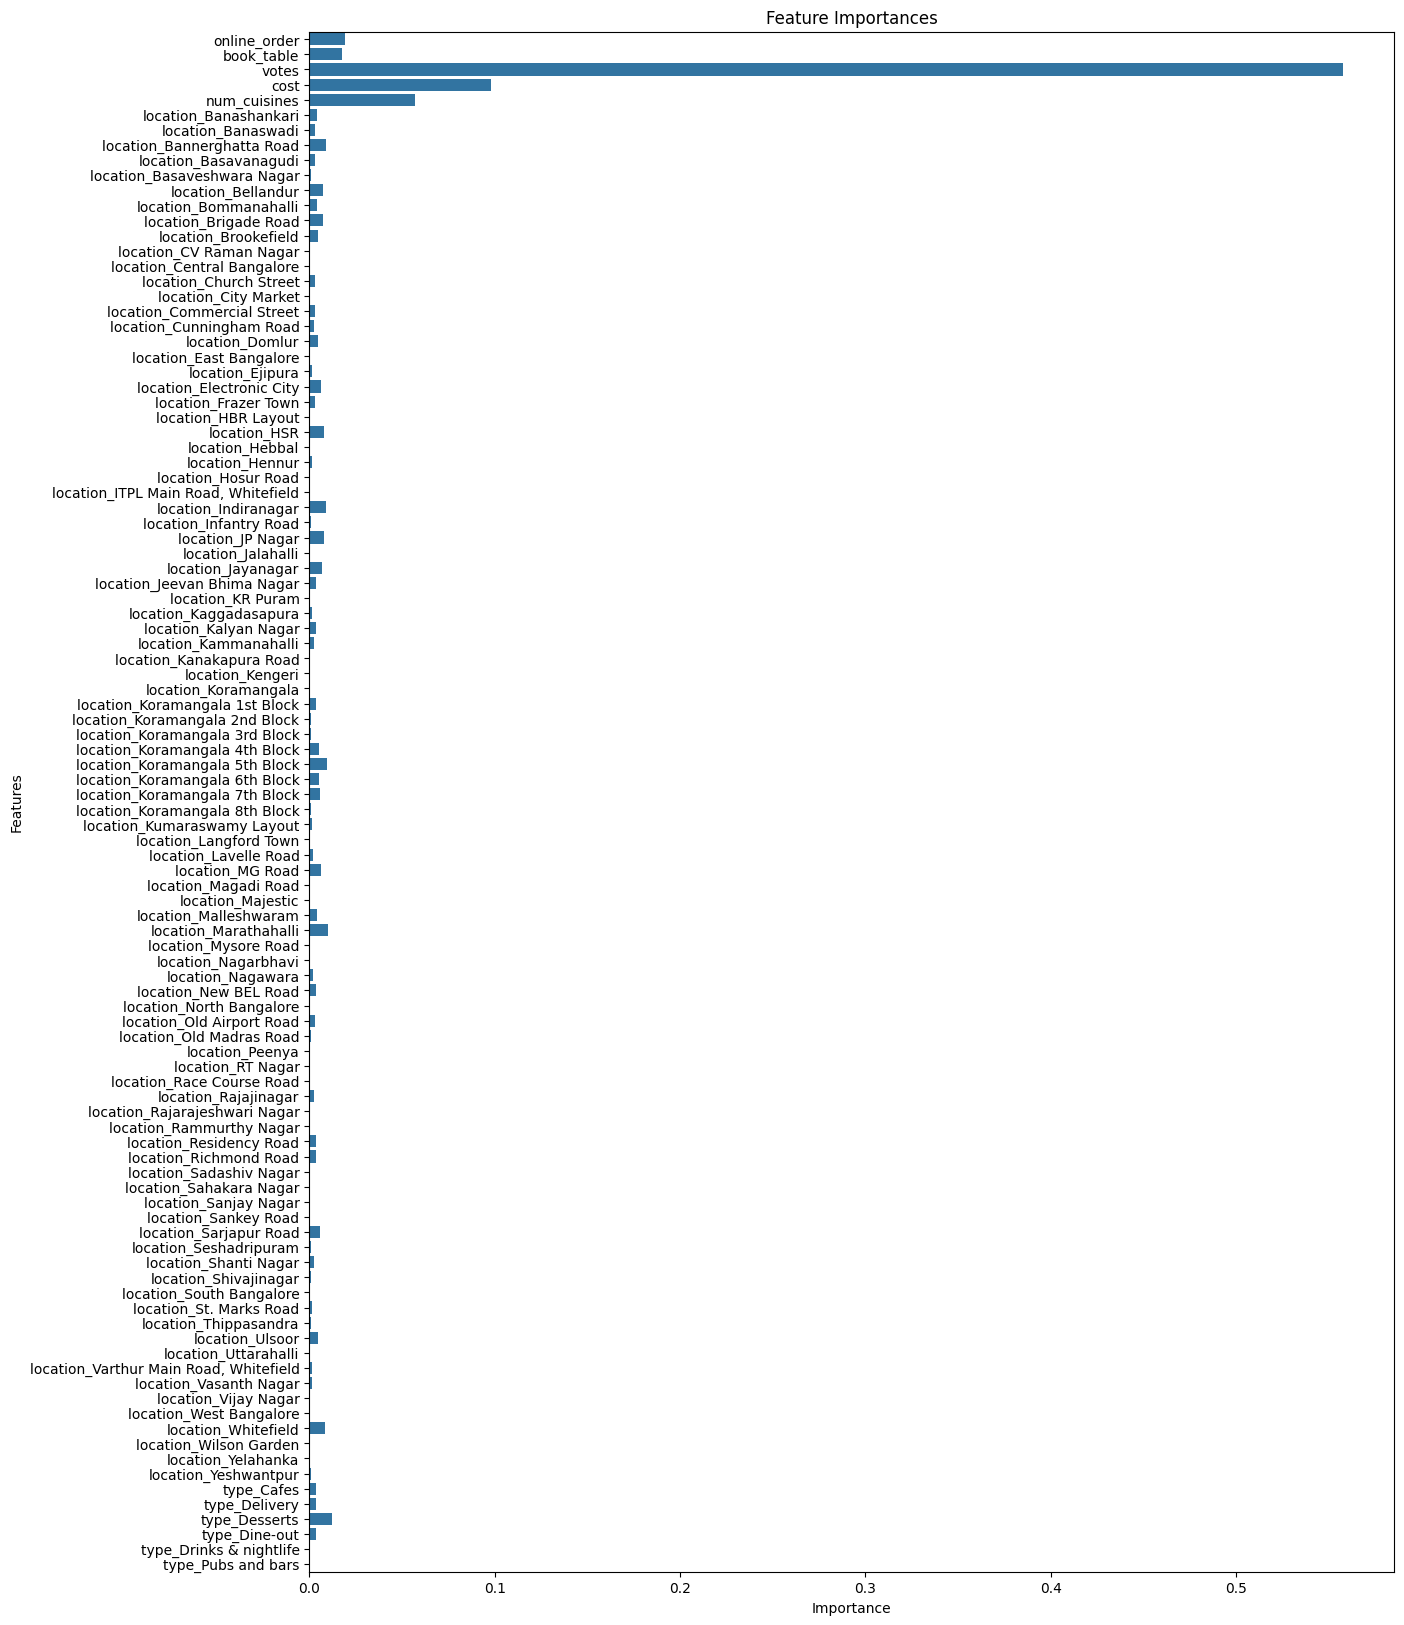

In [ ]:

feature_importances = best_model.feature_importances_
print(len(feature_importances))
print(len(restaurants_df_encoded.drop(columns = ["rate"]).columns))
plt.figure(figsize=(14,20))
sns.barplot(x=feature_importances, y=restaurants_df_encoded.drop(columns = ["rate"]).columns)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")

We can see that the number of votes was especially significant for the random forest regressor model in determing the `rate`.

# Part 6: Hypothesis Testing

Now, we will test our null hypothesis: that a restaurant's location does not signficantly influence the `rate`. We came up with this since, intuitively, a restaurant's location should be relevant since more affluent neighborhoods most likely have more foot traffic and economic flow. Testing this involves residual analysis and permutation testing to evaluate the relationship between the two.

## Section 6.1: One-Hot Encoding without location

To test our null hypothesis, we will preprocess the dataset and encode all categorical variables, similar to our original one-hot encoding, but excluding the influence of `location`.

In [ ]:
# Using One Hot Encoder to encode some non-numeric values
to_encode = ["type"]
no_location_df = restaurants_df.drop(columns=["location"])
# Fit and transform the columns
encoded_data = encoder.fit_transform(no_location_df[to_encode])

# Create a DataFrame for the encoded columns
encoded_columns_df = pd.DataFrame(
    encoded_data,
    columns=encoder.get_feature_names_out(to_encode)
)


# Concatenate the one-hot-encoded columns back to the original DataFrame
restaurants_df_encoded_no_loc = pd.concat([no_location_df, encoded_columns_df], axis=1)

# Drop the original columns that were encoded
restaurants_df_encoded_no_loc = restaurants_df_encoded_no_loc.drop(columns=to_encode)
restaurants_df_encoded_no_loc

,online_order,book_table,rate,votes,cost,num_cuisines,type_Cafes,type_Delivery,type_Desserts,type_Dine-out,type_Drinks & nightlife,type_Pubs and bars
0,0.722868,2.359840,0.906831,0.479415,0.423577,0.341982,0.0,0.0,0.0,0.0,0.0,0.0
1,0.722868,-0.423758,0.906831,0.493009,0.423577,0.341982,0.0,0.0,0.0,0.0,0.0,0.0
2,0.722868,-0.423758,0.226017,0.641407,0.423577,0.341982,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.383378,-0.423758,-0.000921,-0.298826,-0.653198,-0.429004,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.383378,-0.423758,0.226017,-0.210467,-0.007133,-0.429004,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
41405,-1.383378,-0.423758,-0.000921,-0.359998,0.423577,-0.429004,0.0,0.0,0.0,0.0,0.0,1.0
41406,-1.383378,-0.423758,-2.724175,-0.306756,0.423577,1.112968,0.0,0.0,0.0,0.0,0.0,1.0
41407,-1.383378,-0.423758,-0.227859,-0.367928,1.931062,-1.199990,0.0,0.0,0.0,0.0,0.0,1.0
41408,-1.383378,2.359840,1.360706,-0.131170,4.084612,-1.199990,0.0,0.0,0.0,0.0,0.0,1.0


## Section 6.2: Residual testing and permutation testing without location

To evaluate the significance of excluding `location` in predicting `rate`, we will implement a residual analysis and permutation test. First we train a random forest model using the new dataset without `location`, then predict and calculate residuals. The R^2 is computed to establish a benchmark for comparison.

Then we shuffle residuals randomly to create simulated datasets under the null hypothesis. For each shuffled dataset, a new target variable is generated by combining predictions from the baseline model with the shuffled residuals, and a random forest model is trained on the full dataset with this new target variable. The R^2 scores for each shuffled dataset are calcualted and stored to build a distribution of R^2 scores under the null hypothesis.

The p-value is then calculated as the proportion of simulated R^2 scores that exceed the observed R^2 score from the baseline model.

In [ ]:
# TODO: linear regression without the sex_male feature
restaurants_target = restaurants_df_encoded_no_loc['rate']
rf_original = RandomForestRegressor().fit(encoded_data, restaurants_target)
resids = restaurants_target - rf_original.predict(encoded_data)
observed_r2 = rf_original.score(encoded_data, restaurants_target)
simulated_r2_one = []

for _ in range(25):
  # TODO: residual testing
  # shuffle the residual
  np.random.shuffle(resids)
  # predict using the (linear regression without the sex_male feature) from above and plus residual
  T = rf_original.predict(encoded_data) + resids
  # create a new LinearRegression object and fit it on medical_x_processed and T
  nlr = RandomForestRegressor().fit(restaurants_df_encoded, T)

  # calculate the r2 score and append to simulated_r2_one
  simulated_r2_one.append(r2_score(T, nlr.predict(restaurants_df_encoded)))

# TODO: calculate p-value base on original_r2 and simulated_r2
one_zero_p_value = np.sum(np.array(simulated_r2_one) > observed_r2) / 1000

<ipython-input-173-7988e0ee4313>:11: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(resids)
<ipython-input-173-7988e0ee4313>:11: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(resids)
<ipython-input-173-7988e0ee4313>:11: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(resids)
<ipython-input-173-7988e0ee4313>:11: UserWarning: you are shuffling a 'Series' object which is not a su

In [ ]:
print(one_zero_p_value)
print(observed_r2)

0.025
0.04327783450269773


**Results**

Our calculated p-value of 0.025 indicates strong evidence against the null hypothesis since 0.025 < 0.05 (2.5% of simulated R^2 scores generated under the null hypothesis were greater than the observed R^2 score). This suggests that the null hypothesis can be rejected with 95% confidence, implying that `location` has a statistically signficant impact on predicting restaurant ratings, `rate`.

# Part 7: Conclusion

**Key Takeaways**


*   The XGBRegressor with hyperparameter tuning was the best model for predicting our target variable `rate`. We were able to achieve a R^2 value of 0.86.
*   Location plays a statistically significant role in predicting restaurant ratings. While its contribution may not dominate the model, as we saw the our features analysis, it makes a measurable and meaningful impact. Our robust testing method, including shuffling residuals and simulating R^2 scores, ensures that the observed effect was not due to random chance.
*   There are numerous relationships between the dataset, making it far more complex than we imagined. From our analyses, we observed that restaurant type, online ordering availability, table booking options, pricing, and more, show varied relationships with restaurant ratings.




**Future Work**


*   Expand dataset: more features, such as customer demographics or competition density, could be included to enhance predictive accuracy. Can also explore how restaurant ratings evolve over time to capture trends and seasonality.
*   Utilizing dropped data: apply NLP techniques to previously excluded features, such as restaurant names, to uncover potential patterns or branding influences.
*   Model enhancements: explore more advanced modeling techniques like neural networks or other ensemble methods to capture complex nonlinear interactions. Conduct deeper hyperparameter optimization.

**Final Thoughts**


*   This project has been an enriching experience that brought together everything we have learned throughout the semester. It gave us the opportunity to apply diverse skills in a comprehensive way.
*   We were able to understand the critical role EDA plays in uncovering relationships and nuances within a dataset. It was fascinating to observe the complexity of restaurant data.
*   By testing and comparing a variety of modeling approaches, as well as tuning hyperparameters, we learned how each method handles different aspects of prediction tasks, from linear relationships to nonliner patterns.
*   Incorporating hypothesis testing helped us draw significant conclusions with solid statistical evidence.
*   This journey has been both challenging and rewarding, strengthening our technical skills and helping us realize the importance of data analysis. We leave this project looking forward to tackle more complex problems in the future.








